In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [99]:
import pandas as pd
import numpy as np
import nltk
import sklearn
import re  
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial.distance import cdist 
from sklearn import metrics 
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
import collections
from nltk.corpus import stopwords
## For Stemming
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import string
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [0]:
biorix = pd.read_csv('/content/drive/My Drive/results/biorxiv_clean.csv')
clean_pmc = pd.read_csv('/content/drive/My Drive/results/clean_pmc.csv')
clean_comm_use = pd.read_csv('/content/drive/My Drive/results/clean_comm_use.csv')
clean_noncomm_use = pd.read_csv('/content/drive/My Drive/results/clean_noncomm_use.csv')

In [84]:
clean_pmc.columns

Index(['paper_id', 'title', 'authors', 'affiliations', 'abstract', 'text',
       'bibliography', 'raw_authors', 'raw_bibliography'],
      dtype='object')

In [85]:
clean_comm_use.columns

Index(['paper_id', 'title', 'authors', 'affiliations', 'abstract', 'text',
       'bibliography', 'raw_authors', 'raw_bibliography'],
      dtype='object')

In [86]:
clean_noncomm_use.columns

Index(['paper_id', 'title', 'authors', 'affiliations', 'abstract', 'text',
       'bibliography', 'raw_authors', 'raw_bibliography'],
      dtype='object')

In [87]:
biorix.columns

Index(['paper_id', 'title', 'authors', 'affiliations', 'abstract', 'text',
       'bibliography', 'raw_authors', 'raw_bibliography'],
      dtype='object')

In [90]:
frames = [biorix,clean_pmc,clean_comm_use,clean_noncomm_use]

combined = pd.concat(frames)

ERROR! Session/line number was not unique in database. History logging moved to new session 60


In [93]:
combined.tail(10)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography
2343,6edbfac15ca59eb0e18859543190088f7a52112e,VIRsiRNAdb: a curated database of experimental...,"Nishant Thakur, Abid Qureshi, Manoj Kumar",Nishant Thakur (Council of Scientific and Indu...,NaN,INTRODUCTION\n\nViral diseases remain one of t...,"Emerging viral diseases, S T Nichol, J Arikawa...","[{'first': 'Nishant', 'middle': [], 'last': 'T...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Emergin..."
2344,5ed43fc646fb368da6a9cf9d0029891a4b8248d1,An Ion-transporting ATPase Encodes Multiple Ap...,"Cara J Gottardi, Michael J Caplan","Cara J Gottardi, Michael J Caplan",Abstract\n\nEpithelial cells accumulate distin...,\n\nT rIn plasma membranes of polarized epithe...,"Mutual dependence of Na,K-ATPase alpha and bet...","[{'first': 'Cara', 'middle': ['J'], 'last': 'G...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Mutual ..."
2345,496bfe6fe82dca285afe74c0202ad9498b41370c,Infection & Chemotherapy 성인 급성 상기도 감염 항생제 사용지침...,NaN,NaN,Abstract\n\nThis guideline was developed as pa...,"\n\n.\n\nI. 머리말\n\n1. 배경 및 목적 2-5 [1] . 40%, 1...","Epidemiology of viral respiratory infections, ...",[],"{'BIBREF0': {'ref_id': 'b0', 'title': 'Epidemi..."
2346,3290019883fad88c1c40279e2783a739dc7363fa,Supplementary Information Bats as reservoirs o...,"Jan Felix Drexler, Victor Max Corman, Marcel A...",Jan Felix Drexler (University of Bonn Medical ...,NaN,Supplementary Figure S4 Occurrence of African ...,Nipah virus infection in bats (order Chiropter...,"[{'first': 'Jan', 'middle': ['Felix'], 'last':...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Nipah v..."
2347,5a1a3d864a2110b730b3cbf6b7a1c01a0870be42,BENTHAM SCIENCE Impact Factor: 1.041 BENTHAM S...,"Chelsea N Powers, William N Setzer",Chelsea N Powers (University of Alabama in Hun...,Abstract\n\nA virtual screening analysis of ou...,INTRODUCTION\n\nDengue fever is an acute viral...,"The global distribution and burden of dengue, ...","[{'first': 'Chelsea', 'middle': ['N'], 'last':...","{'BIBREF0': {'ref_id': 'b0', 'title': 'The glo..."
2348,3b8b2a835cfa770c6cef711d52e1f1e869d8aca8,Tumor-Treating Fields Induce RAW264.7 Macropha...,"Jeong-In Park, Kyung-Hee Song, Seung-Youn Jung...","Jeong-In Park, Kyung-Hee Song, Seung-Youn Jung...",Abstract\n\nObjective: Tumor-treating fields a...,Introduction\n\nTumor-treating fields (TTFs) t...,NovoTTF-100A versus physician's choice chemoth...,"[{'first': 'Jeong-In', 'middle': [], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': ""NovoTTF..."
2349,500e585afac01e4b3847aa138db86b04352484c5,Efficacy and safety of Chou-Ling-Dan granules ...,"Jiayang He, Zhengtu Li, Wanyi Huang, Wenda Gua...","Jiayang He, Zhengtu Li, Wanyi Huang, Wenda Gua...",NaN,\n\nIntroduction Chou-Ling-Dan (CLD) (Laggerap...,Effect of the epidemiological heterogeneity on...,"[{'first': 'Jiayang', 'middle': [], 'last': 'H...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Effect ..."
2350,87f178ed1bcc5a747200ccd4adf42d883afd9fb7,Complete Genome Sequences of the SARS-CoV: the...,"Shengli Bi, E&apos;de Qin, Zuyuan Xu, Wei Li,...","Shengli Bi, E&apos;de Qin (Chinese Academy of...",Abstract\n\nBeijing has been one of the epicen...,\n\nAccumulated number of probable cases and d...,Ile(16)/Leu(1) 214 (7.5) 26.6-27.1 43.5-43.9 (...,"[{'first': 'Shengli', 'middle': [], 'last': 'B...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Ile(16)..."
2351,5d4f1f02d0e731966dddd635e8fa7bfdc169d3b9,Case Report A Rare Case of Autoimmune Polyglan...,"Ryan Kenneth Smith, Beaumont Health, Peter M G...","Ryan Kenneth Smith, Beaumont Health, Peter M G...","Abstract\n\nAdrenal insufficiency is a rare, p...",Introduction\n\nAdrenal insufficiency is decre...,"Adrenal insufficiency, E Charmandari, N C Nico...","[{'first': 'Ryan', 'middle': ['Kenneth'], 'las...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Adrenal..."
2352,c64c4f6efb9878bcc31980393c199d997805132a,Factors influencing Dipylidium sp. infection i...,"Marion L East, Christoph Kurze, Kerstin Wilhel...",Mari

In [0]:
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [0]:
def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))  
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:        
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

In [0]:
NewList=[]

lemmatizer = WordNetLemmatizer()


for word in combined['text']:
    
    word=lemmatize_sentence(word)
    word=word.lower()
    word=word.strip("\n")
    word=word.replace(","," ")
    word=word.replace("  "," ")
    word=word.replace("_","")
    word=re.sub(r'\b\w{1,3}\b', '',word)
    word=re.sub(r'\+', ' ',word)
    word=re.sub(r'.*\+\n', '',word)
    word=re.sub(r'\W',' ', word)
    word=re.sub(r'\d',' ', word)
    word=re.sub(r'\s+',' ', word)
    word=word.replace("\t","")
    word=word.replace(".","")
    word=word.replace("!","")
    word=word.replace("'","")
    word=word.replace("-","")
    word=word.replace("?","")
    word=word.replace("\n","")
    word=word.lstrip()
    word=word.rstrip()
    word=word.strip()

    NewList.append(word)

In [0]:
tokenized_list = [word_tokenize(i) for i in NewList]

In [7]:
stop_words = stopwords.words('english')
more_stop_words = ['https','peer','author','reviewed','license','funder','copyright','introduction','preprint','biorxiv','medrxiv']
stop_words.extend(more_stop_words)
stop_words = [w for w in stop_words if not w == 't']
stop_words = stop_words + [w.replace("'","") for w in stop_words]


biorix['tokenized'] = tokenized_list

biorix['tokenized'] = biorix['tokenized'].apply(lambda x: [item for item in x if item not in stop_words])

biorix['tokenized'].head(2)

0    [airborne, mediated, microbial, diseases, repr...
1    [december, outbreak, novel, disease, covid, ca...
Name: tokenized, dtype: object

In [0]:
from nltk.tokenize.treebank import TreebankWordDetokenizer

dt = []
for i in biorix['tokenized']:
    dt.append(TreebankWordDetokenizer().detokenize(i))

In [0]:
# Use count vectorizer to vectorize
CV_lda = CountVectorizer(input='content')

count_vectorized_main_lda = CV_lda.fit_transform(dt)

column_names_main_lda = CV_lda.get_feature_names()

vectorized_df_main_lda = pd.DataFrame(count_vectorized_main_lda.toarray(), columns=column_names_main_lda)

In [10]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=6,n_jobs=-1)
lda.fit(vectorized_df_main_lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=6, n_jobs=-1,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [0]:
import pyLDAvis.sklearn as LDAvis
import pyLDAvis

panel = LDAvis.prepare(lda, count_vectorized_main_lda, CV_lda, mds='tsne')
pyLDAvis.display(panel)

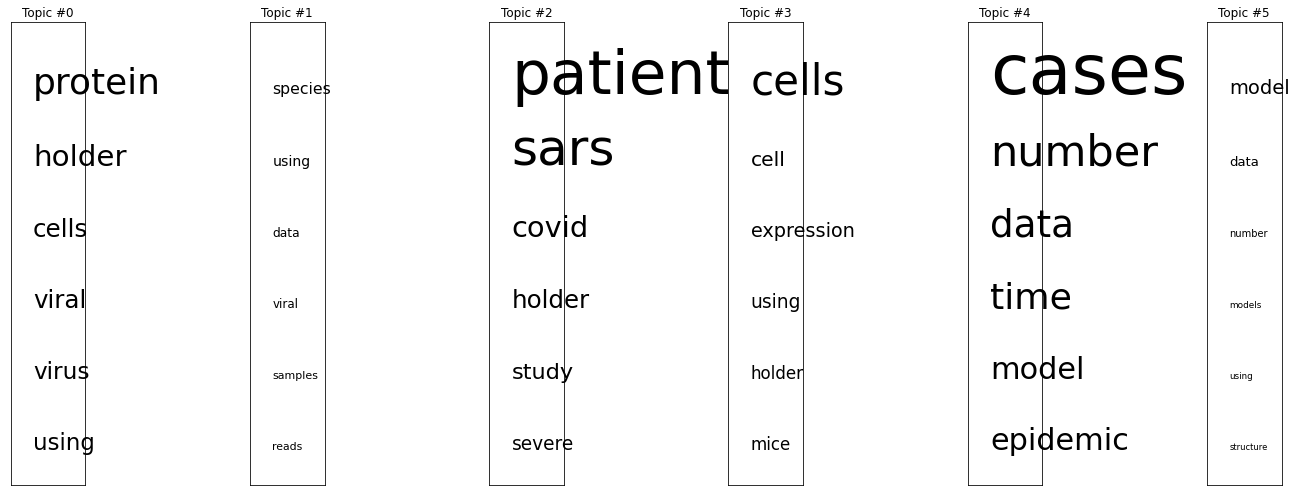

In [11]:
%matplotlib inline
word_topic = np.array(lda.components_)
word_topic = word_topic.transpose()
num_topics = 6

num_top_words = 6
vocab_array = np.asarray(column_names_main_lda)

fontsize_base = 70 / np.max(word_topic) # font size for word with largest share in corpus

fig = plt.figure(figsize=(18,7))
for t in range(num_topics):
    plt.subplot(1, num_topics, t + 1)  # plot numbering starts with 1
    plt.ylim(0, num_top_words + 0.5)  # stretch the y-axis to accommodate the words
    plt.xticks([])  # remove x-axis markings ('ticks')
    plt.yticks([]) # remove y-axis markings ('ticks')
    plt.title('Topic #{}'.format(t))
    top_words_idx = np.argsort(word_topic[:,t])[::-1]  # descending order
    top_words_idx = top_words_idx[:num_top_words]
    top_words = vocab_array[top_words_idx]
    top_words_shares = word_topic[top_words_idx, t]
    for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
        plt.text(0.3, num_top_words-i-0.5, word, fontsize=fontsize_base*share)

plt.tight_layout()
plt.show()

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

tf_vectorizer = TfidfVectorizer(input='content')

tfidf = tf_vectorizer.fit_transform(dt)
tfidf_norm = normalize(tfidf)
tf_idf_array = tfidf_norm.toarray()

In [0]:
pca = PCA(n_components=6)

tf = pca.fit_transform(tf_idf_array)

km = KMeans(n_clusters=6, random_state=0).fit(tf)

prediction = km.predict(tf)

In [0]:
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 

for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(tf) 
    kmeanModel.fit(tf)     
      
    distortions.append(sum(np.min(cdist(tf, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / tf.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(tf, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / tf.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

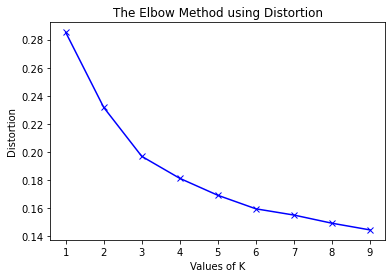

In [0]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

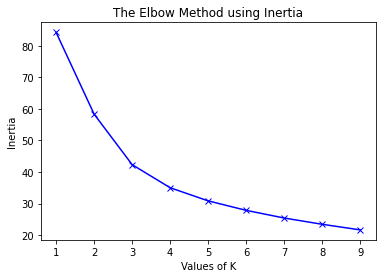

In [0]:
plt.plot(K, inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

Text(0.5, 1.0, 'Clusters')

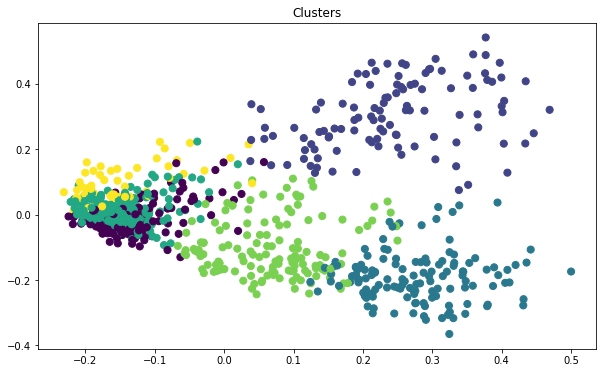

In [0]:
fig = plt.figure(figsize=(10,6))
plt.scatter(tf[:,0],tf[:,1],c=prediction, s=50, cmap='viridis')
plt.title('Clusters')

In [0]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label)
        #print(id_temp)
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        #print(x_means)
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(tf_idf_array, prediction, 15)

In [15]:
dfs

[      features     score
 0          ace  0.171057
 1         sars  0.160448
 2         ncov  0.131648
 3      protein  0.098603
 4     epitopes  0.071143
 5      binding  0.070213
 6         cell  0.062229
 7        spike  0.052024
 8     receptor  0.048721
 9     proteins  0.048175
 10       cells  0.046691
 11       human  0.041487
 12    sequence  0.038290
 13  expression  0.036362
 14      holder  0.034435,       features     score
 0      species  0.053506
 1        reads  0.049120
 2    sequences  0.047137
 3      viruses  0.044436
 4       genome  0.043322
 5        viral  0.040437
 6     sequence  0.039379
 7   sequencing  0.036863
 8        virus  0.033705
 9         host  0.032842
 10      holder  0.032812
 11        sars  0.032205
 12     samples  0.031555
 13       using  0.031199
 14     genomes  0.027512,         features     score
 0          cases  0.168735
 1          wuhan  0.106234
 2       epidemic  0.100047
 3         number  0.092509
 4          china  0.080934


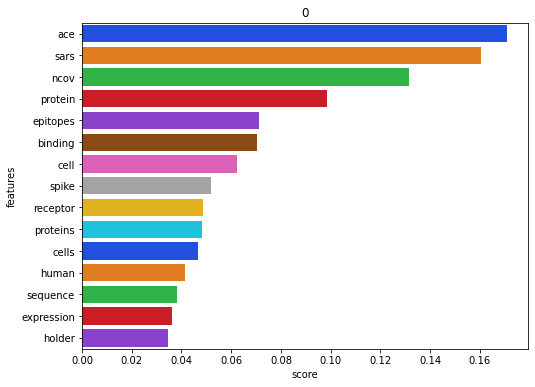

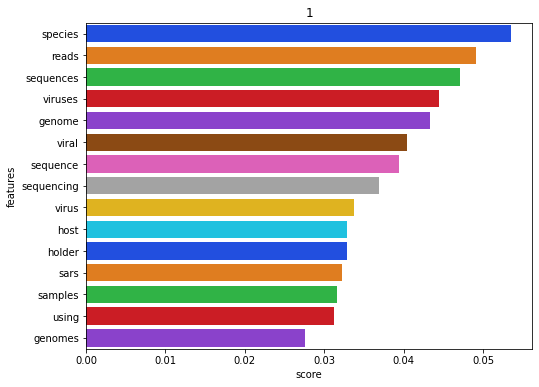

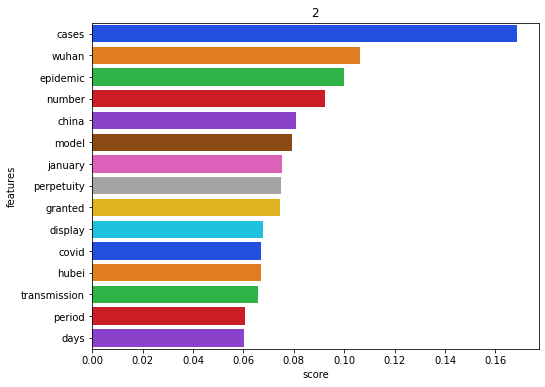

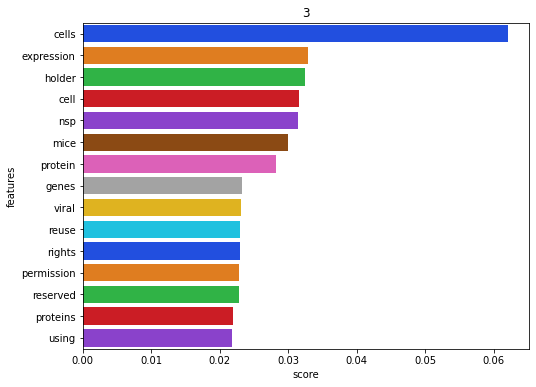

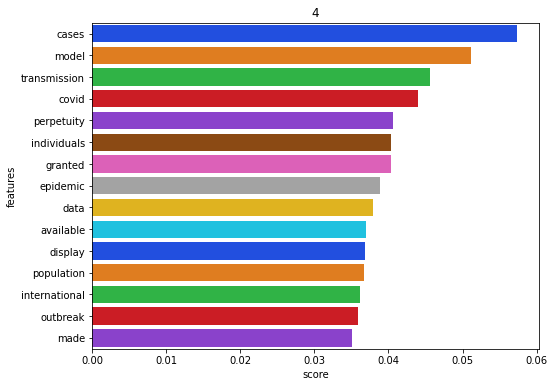

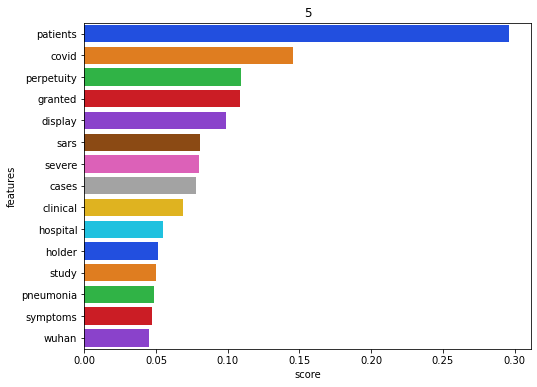

In [16]:
j = 0
for i in dfs:
    plt.figure(figsize=(8,6))
    sns.barplot(x='score',y='features',orient='h',data=i[:15],palette='bright').set_title(j)
    j += 1

In [0]:
biorix['clusters'] = prediction

In [0]:
cluster_0 = biorix[biorix['clusters'] == 0]
cluster_5 = biorix[biorix['clusters'] == 5]

In [32]:
print("Amount of articles in cluster 0:",len(cluster_0))
print("Amount of articles in cluster 5:",len(cluster_5))

Amount of articles in cluster 0: 71
Amount of articles in cluster 5: 110


In [0]:
dt_cluster_0 = []
for i in cluster_0['tokenized']:
    dt_cluster_0.append(TreebankWordDetokenizer().detokenize(i))

dt_cluster_5 = []
for i in cluster_5['tokenized']:
    dt_cluster_5.append(TreebankWordDetokenizer().detokenize(i))

In [0]:
tf_vectorizer_0 = TfidfVectorizer(input='content')

tfidf_0 = tf_vectorizer_0.fit_transform(dt_cluster_0)
tfidf_norm_0 = normalize(tfidf_0)
tf_idf_array_0 = tfidf_norm_0.toarray()

pca_0 = PCA(n_components=6)

tf_0 = pca_0.fit_transform(tf_idf_array_0)

In [0]:
tf_vectorizer_5 = TfidfVectorizer(input='content')

tfidf_5 = tf_vectorizer_5.fit_transform(dt_cluster_5)
tfidf_norm_5 = normalize(tfidf_5)
tf_idf_array_5 = tfidf_norm_5.toarray()

pca_5 = PCA(n_components=6)

tf_5 = pca_5.fit_transform(tf_idf_array_5)

In [0]:
km_cluster_0 = KMeans(n_clusters=6, random_state=0).fit(tf_0)

prediction_cluster_0 = km_cluster_0.predict(tf_0)

km_cluster_5 = KMeans(n_clusters=6, random_state=0).fit(tf_5)

prediction_cluster_5 = km_cluster_5.predict(tf_5)

Text(0.5, 1.0, 'Cluster 0 Clusters')

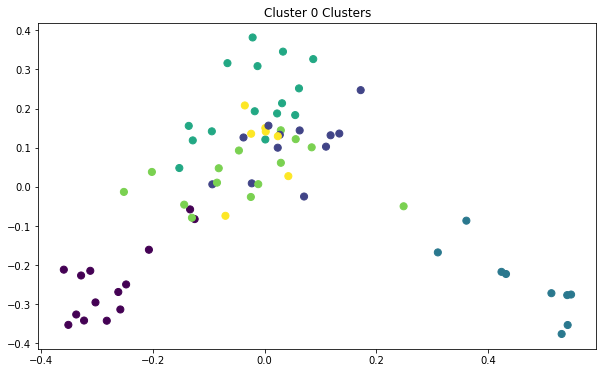

In [41]:
fig = plt.figure(figsize=(10,6))
plt.scatter(tf_0[:,0],tf_0[:,1],c=prediction_cluster_0, s=50, cmap='viridis')
plt.title('Cluster 0 Clusters')

Text(0.5, 1.0, 'Cluster 5 Clusters')

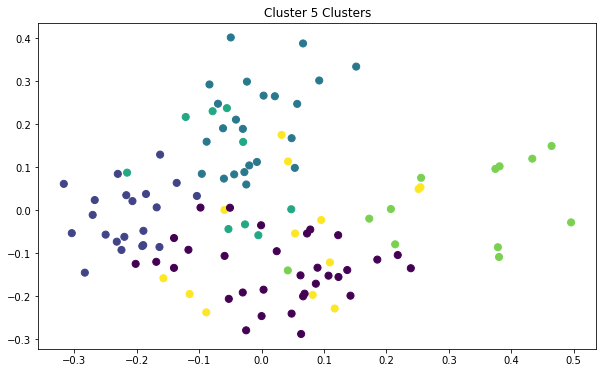

In [42]:
fig = plt.figure(figsize=(10,6))
plt.scatter(tf_5[:,0],tf_5[:,1],c=prediction_cluster_5, s=50, cmap='viridis')
plt.title('Cluster 5 Clusters')

In [0]:
dfs_cluster_0 = get_top_features_cluster(tf_idf_array_0, prediction_cluster_0, 15)
dfs_cluster_5 = get_top_features_cluster(tf_idf_array_5, prediction_cluster_5, 15)

In [44]:
dfs_cluster_0

[      features     score
 0          ace  0.204731
 1   expression  0.163945
 2        cells  0.111394
 3         cell  0.091370
 4         ncov  0.081315
 5     patients  0.079985
 6   perpetuity  0.076621
 7      granted  0.074305
 8       kidney  0.070637
 9         sars  0.069252
 10       liver  0.068841
 11     display  0.065035
 12        lung  0.062909
 13     tissues  0.059131
 14        data  0.054319,         features     score
 0           sars  0.289494
 1             cr  0.141065
 2       antibody  0.085314
 3        protein  0.084578
 4     antibodies  0.079218
 5             cd  0.072041
 6         figure  0.063793
 7          cross  0.058645
 8            nsp  0.057540
 9        binding  0.057062
 10         cells  0.054562
 11            ek  0.052040
 12     structure  0.051735
 13           orf  0.048677
 14  neutralizing  0.048210,       features     score
 0     epitopes  0.389848
 1         cell  0.161507
 2      epitope  0.148795
 3      protein  0.125586
 4   p

In [45]:
dfs_cluster_5

[        features     score
 0           mlce  0.253420
 1      concerned  0.159819
 2        blooded  0.119398
 3     prevalence  0.083189
 4    instability  0.079786
 5   histological  0.078789
 6         assume  0.074072
 7        cascade  0.064319
 8       removing  0.062101
 9     facilitate  0.060905
 10  monophyletic  0.060718
 11       dataset  0.060718
 12    constantly  0.058817
 13        nation  0.055486
 14          rfix  0.054943,          features     score
 0            mlce  0.308197
 1       concerned  0.134340
 2    prototypical  0.114380
 3         plotted  0.090514
 4   precipitation  0.090514
 5      alignments  0.090514
 6            post  0.090514
 7        monomers  0.089594
 8      subjective  0.087410
 9      facilitate  0.083540
 10   monophyletic  0.083540
 11        dataset  0.083540
 12     prevalence  0.082239
 13       removing  0.076661
 14           form  0.075346,          features     score
 0            mlce  0.142511
 1      facilitate  0.079878
 

Cluster 0 Clusters - ACE


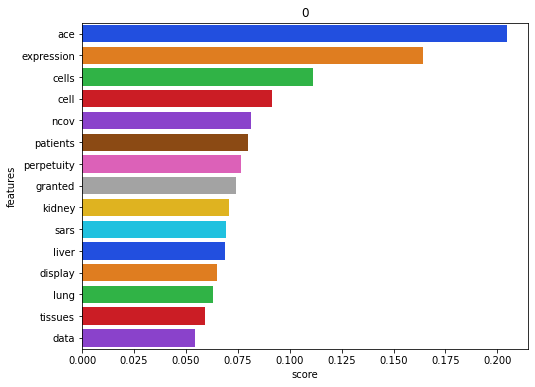

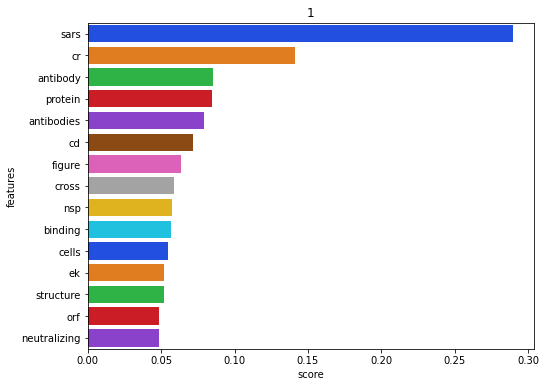

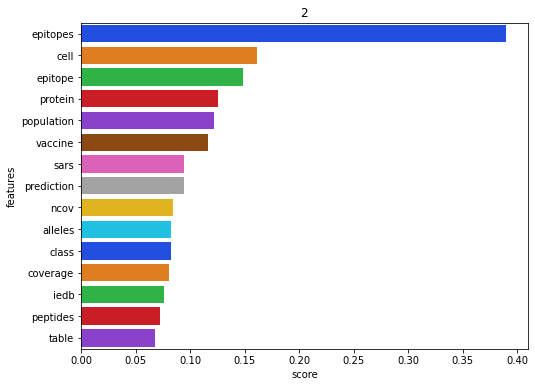

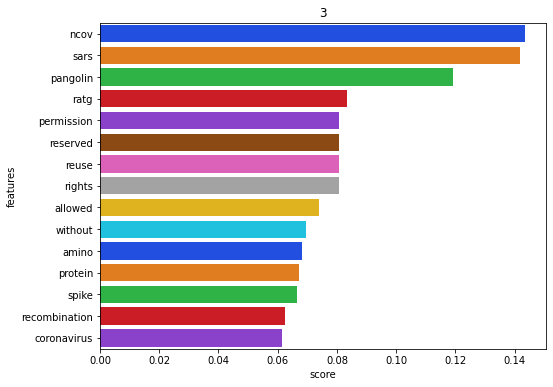

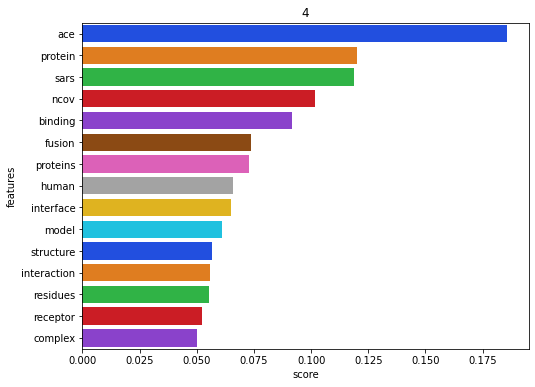

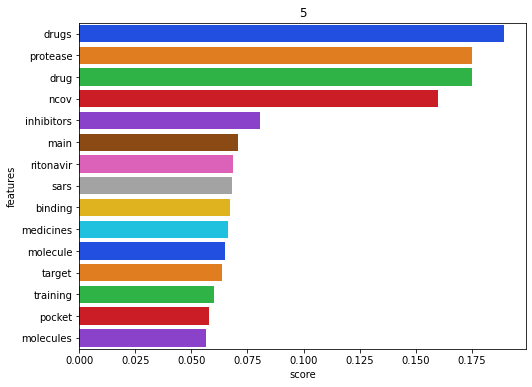

In [48]:
print('Cluster 0 Clusters - ACE')
j = 0
for i in dfs_cluster_0:
    plt.figure(figsize=(8,6))
    sns.barplot(x='score',y='features',orient='h',data=i[:15],palette='bright').set_title(j)
    j += 1

Cluster 0 Clusters - Possible Symptoms


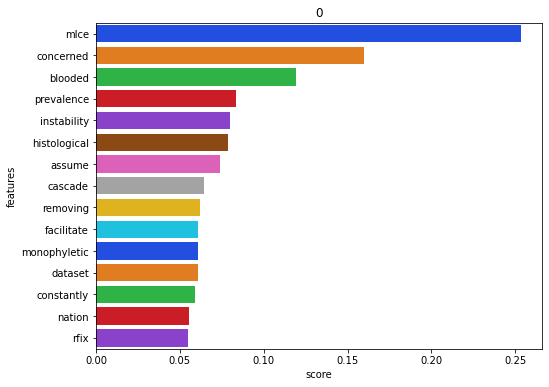

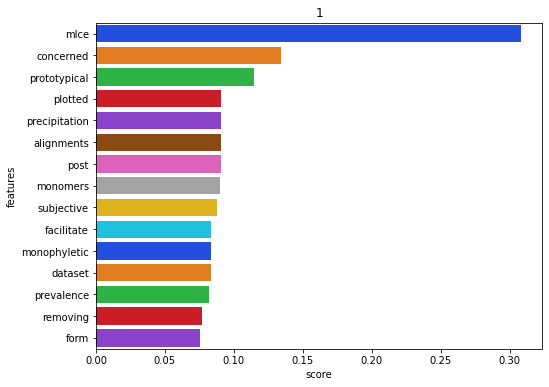

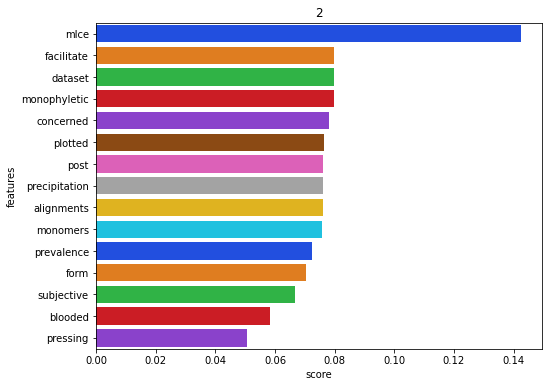

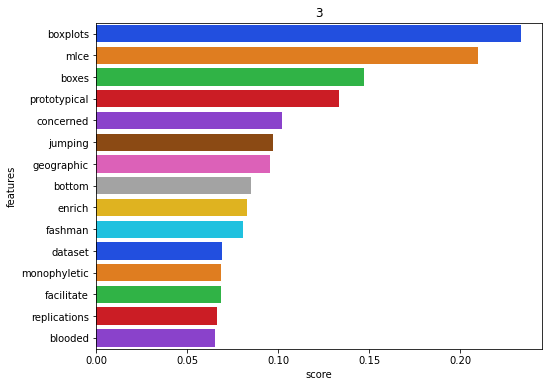

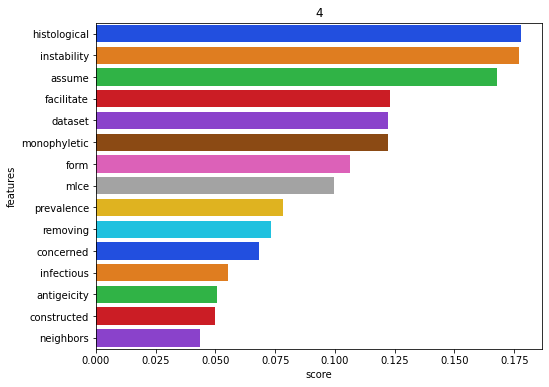

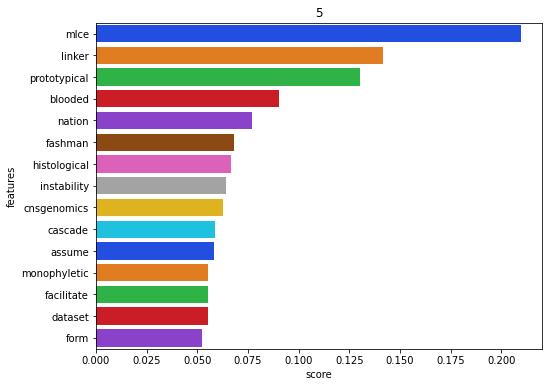

In [49]:
print('Cluster 0 Clusters - Possible Symptoms')

j = 0
for i in dfs_cluster_5:
    plt.figure(figsize=(8,6))
    sns.barplot(x='score',y='features',orient='h',data=i[:15],palette='bright').set_title(j)
    j += 1

In [0]:
cluster_5.to_csv('/content/drive/My Drive/results/cluster_5_articles.csv',index=False)

In [67]:
cluster_5['tokenized']

1      [december, outbreak, novel, disease, covid, ca...
6      [outbreak, covid, began, wuhan, china, early, ...
25     [december, pneumonia, unknown, cause, emerged,...
27     [coronaviruses, large, family, respiratory, vi...
30     [arising, wuhan, south, china, seafood, market...
                             ...                        
849    [december, outbreak, coronavirus, disease, cov...
870    [coronavirus, disease, outbreak, rapidly, expa...
873    [results, apart, clinical, features, described...
880    [since, december, clusters, unexplained, pneum...
883    [recent, outbreak, novel, coronavirus, decembe...
Name: tokenized, Length: 110, dtype: object

In [0]:
symptoms = []
for i in cluster_5['tokenized']:
  for j in i:
      symptoms.append(j.split('symptoms',maxsplit=10))

In [0]:
from itertools import chain

symptoms = list(chain.from_iterable(symptoms))

In [0]:
#Get counts for creating graph
counted_words = collections.Counter(list(symptoms))

words = []
counts = []

for letter,count in counted_words.most_common(500):
  words.append(letter)
  counts.append(count)

In [81]:
df = pd.DataFrame(columns=['words','count'])

df['words'] = words
df['count'] = counts

df = df.drop(index=6)

df.head(10)

,words,count
0,patients,3889
1,covid,1728
2,cases,1267
3,granted,1166
4,display,1164
5,perpetuity,1163
7,severe,1065
8,sars,1060
9,holder,1043
10,study,975


<BarContainer object of 99 artists>

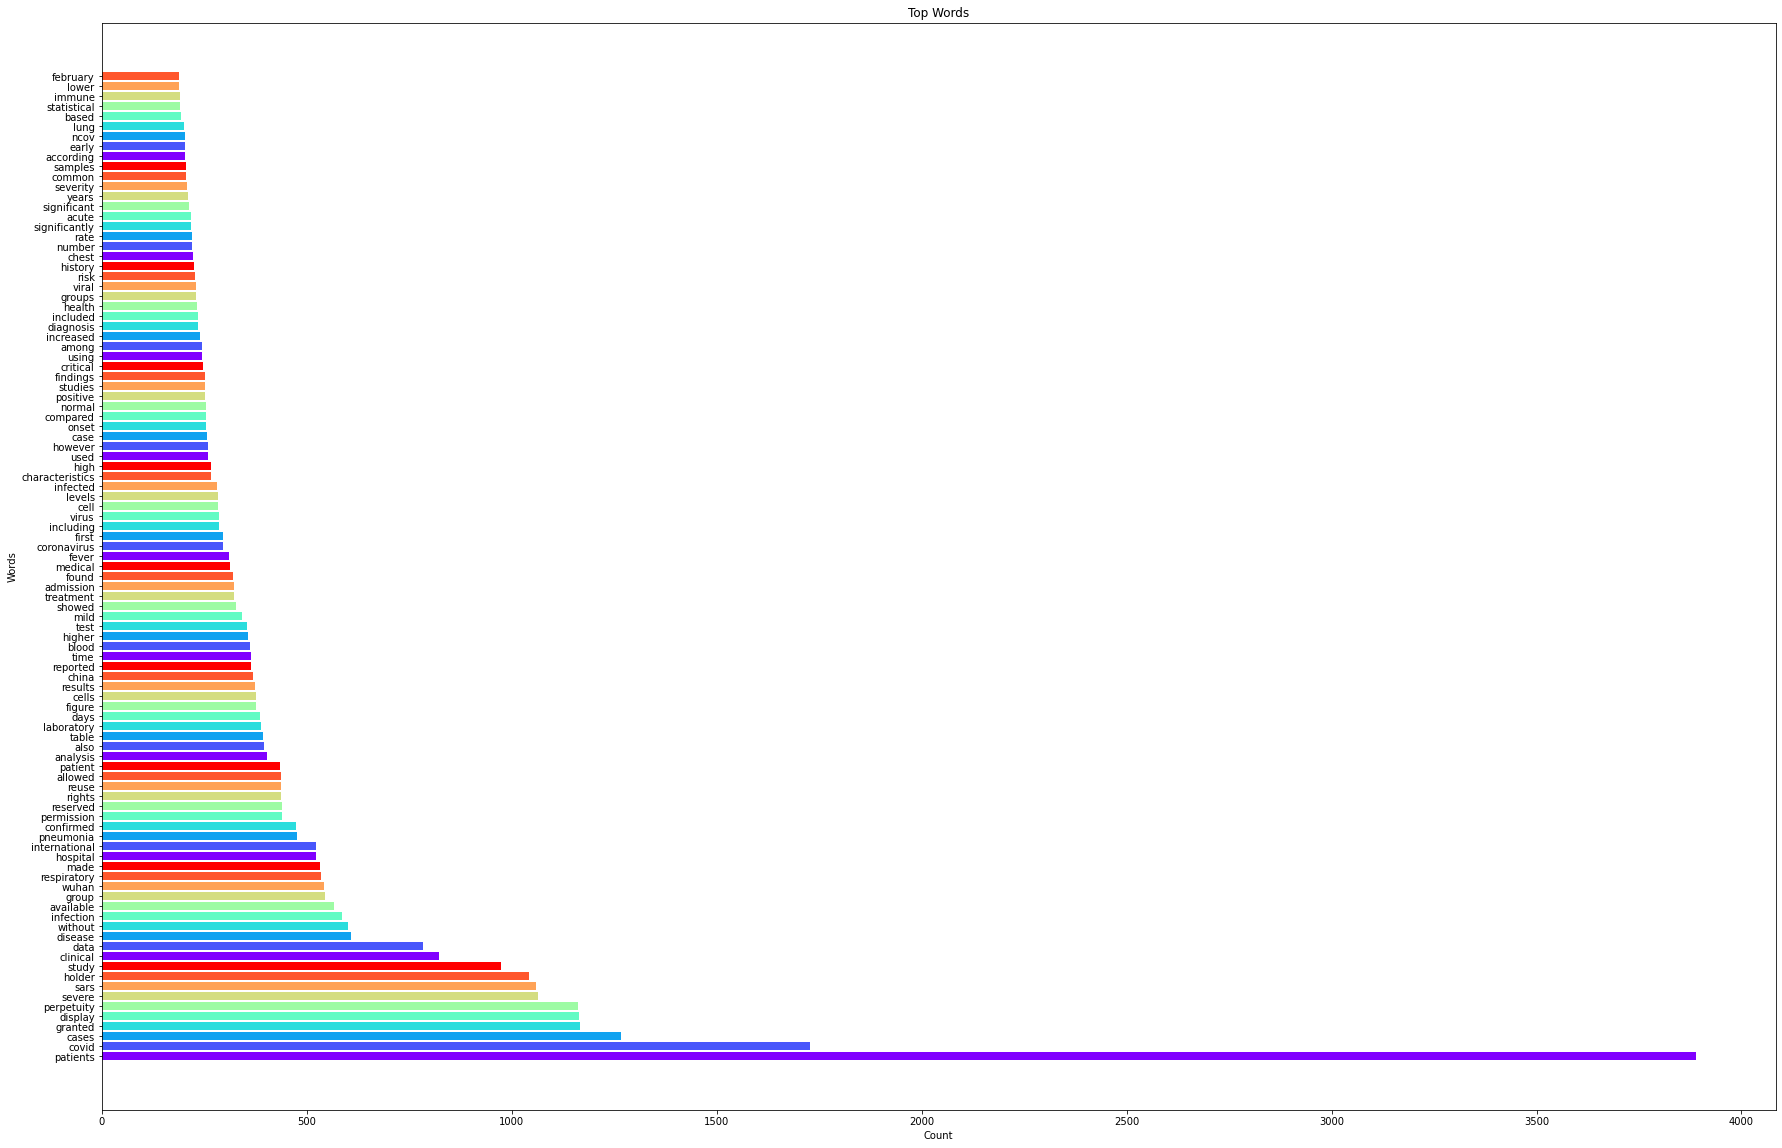

In [82]:
colors = cm.rainbow(np.linspace(0, 1, 10))
rcParams['figure.figsize'] = 30, 20

plt.title("Top Words")
plt.xlabel('Count')
plt.ylabel('Words')
plt.barh(df['words'][0:99], df['count'][0:99], color=colors)